# Julia 深度學習：類神經網路模型簡介

## 作業 032：訓練 MLP 學習門牌號碼資料集

訓練一個 MLP 模型來學習門牌號碼資料集。

注意：MLP 模型的能力有限，可能會導致訓練起來效果不佳。

注意：近期 Flux 正在持續更新，請確保您的 Julia 在 v1.3 版以上，以及 Flux 在 v0.10.4 以上或是最新版。

In [1]:
using Flux
using Flux.Data: DataLoader
using Flux: @epochs, onecold, onehotbatch, throttle, logitcrossentropy
using MLDatasets
using Statistics
using ImageCore # SVHN2.convert2image(SVHN2.traindata(1)[1])

┌ Info: Precompiling MLDatasets [eb30cadb-4394-5ae3-aed4-317e484a6458]
└ @ Base loading.jl:1260


## 關於 The Street View House Numbers (SVHN) Dataset

SVHN format 2 · MLDatasets.jl  
https://juliaml.github.io/MLDatasets.jl/latest/datasets/SVHN2/

The Street View House Numbers (SVHN) Dataset  
http://ufldl.stanford.edu/housenumbers/

## 讀取資料

呼叫 SVHN2 資料集的過程中，會先去檢查以前是否有下載過，如果是第一次下載，過程中會詢問是否下載資料集，請回答 `y`。整個資料集的大小約為 1.6 GB，下載時間可能會稍久，請耐心等候。

In [2]:
train_X, train_y = SVHN2.traindata(Float32)

(Float32[0.12941177 0.10980392 … 0.32941177 0.33333334; 0.05882353 0.05490196 … 0.3372549 0.34901962; … ; 0.32156864 0.2627451 … 0.41568628 0.42745098; 0.34901962 0.3254902 … 0.41568628 0.40392157]

Float32[0.11764706 0.15294118 … 0.3372549 0.34509805; 0.09019608 0.09803922 … 0.30980393 0.32156864; … ; 0.3019608 0.22745098 … 0.4117647 0.4117647; 0.30980393 0.30588236 … 0.40784314 0.41568628]

Float32[0.14901961 0.13725491 … 0.2509804 0.26666668; 0.07450981 0.08627451 … 0.28235295 0.28235295; … ; 0.22352941 0.20392157 … 0.33333334 0.3372549; 0.23137255 0.23529412 … 0.3372549 0.30980393]

Float32[0.32941177 0.33333334 … 0.40392157 0.40392157; 0.3372549 0.3254902 … 0.41568628 0.40392157; … ; 0.34509805 0.34509805 … 0.40392157 0.40784314; 0.34509805 0.34509805 … 0.4117647 0.40392157]

Float32[0.29803923 0.3019608 … 0.40784314 0.41568628; 0.28627452 0.28627452 … 0.40784314 0.4117647; … ; 0.3019608 0.30980393 … 0.40392157 0.40784314; 0.30588236 0.31764707 … 0.3882353 0.38431373]

Float32[0.2

In [3]:
test_X,  test_y  = SVHN2.testdata(Float32)

(Float32[0.14901961 0.15294118 … 0.19607843 0.1882353; 0.15294118 0.15294118 … 0.2 0.1882353; … ; 0.16470589 0.16862746 … 0.1764706 0.17254902; 0.15294118 0.15294118 … 0.16470589 0.16470589]

Float32[0.40392157 0.40784314 … 0.45882353 0.4509804; 0.40784314 0.40784314 … 0.4627451 0.4509804; … ; 0.40392157 0.39607844 … 0.45490196 0.4509804; 0.38039216 0.38039216 … 0.44313726 0.44313726]

Float32[0.23529412 0.23921569 … 0.29803923 0.2901961; 0.23921569 0.23921569 … 0.3019608 0.2901961; … ; 0.24313726 0.24705882 … 0.28235295 0.2784314; 0.22352941 0.22352941 … 0.27058825 0.2784314]

Float32[0.5058824 0.5254902 … 0.5411765 0.5137255; 0.49803922 0.52156866 … 0.50980395 0.47843137; … ; 0.48235294 0.49411765 … 0.39607844 0.43529412; 0.48235294 0.49019608 … 0.4392157 0.48235294]

Float32[0.5568628 0.5882353 … 0.59607846 0.5686275; 0.56078434 0.58431375 … 0.5647059 0.53333336; … ; 0.5254902 0.5372549 … 0.41960785 0.4627451; 0.5294118 0.5372549 … 0.4627451 0.50980395]

Float32[0.6 0.627451 … 0.647

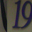

In [4]:
SVHN2.convert2image(SVHN2.traindata(1)[1])

In [5]:
SVHN2.trainlabels(1)

1

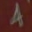

In [6]:
SVHN2.convert2image(SVHN2.extratensor(1))

In [7]:
SVHN2.extralabels(1)

4

In [8]:
train_X = Flux.flatten(train_X)

3072×73257 Array{Float32,2}:
 0.129412   0.329412   0.0745098  0.0705882  …  0.360784  0.745098  0.847059
 0.0588235  0.337255   0.0784314  0.0588235     0.368627  0.803922  0.866667
 0.0588235  0.301961   0.0980392  0.0431373     0.447059  0.862745  0.886275
 0.164706   0.329412   0.0941176  0.0392157     0.584314  0.894118  0.890196
 0.262745   0.317647   0.101961   0.0392157     0.729412  0.898039  0.894118
 0.266667   0.239216   0.113725   0.121569   …  0.756863  0.886275  0.890196
 0.266667   0.105882   0.105882   0.172549      0.741176  0.870588  0.890196
 0.290196   0.0784314  0.109804   0.207843      0.752941  0.866667  0.890196
 0.305882   0.188235   0.152941   0.227451      0.807843  0.866667  0.886275
 0.345098   0.298039   0.207843   0.231373      0.847059  0.882353  0.898039
 0.329412   0.333333   0.282353   0.243137   …  0.847059  0.882353  0.87451
 0.309804   0.321569   0.337255   0.278431      0.8       0.87451   0.839216
 0.309804   0.32549    0.34902    0.278431      

In [9]:
test_X = Flux.flatten(test_X)

3072×26032 Array{Float32,2}:
 0.14902   0.505882  0.588235  0.509804  …  0.45098   0.376471  0.396078
 0.152941  0.498039  0.588235  0.505882     0.454902  0.380392  0.392157
 0.152941  0.490196  0.596078  0.498039     0.458824  0.380392  0.388235
 0.160784  0.490196  0.603922  0.486275     0.454902  0.376471  0.384314
 0.168627  0.498039  0.611765  0.501961     0.458824  0.372549  0.376471
 0.172549  0.498039  0.603922  0.513726  …  0.466667  0.364706  0.364706
 0.176471  0.494118  0.584314  0.521569     0.470588  0.360784  0.34902
 0.184314  0.482353  0.556863  0.521569     0.470588  0.352941  0.345098
 0.184314  0.482353  0.545098  0.52549      0.462745  0.352941  0.337255
 0.184314  0.486275  0.556863  0.529412     0.458824  0.356863  0.333333
 0.184314  0.494118  0.576471  0.529412  …  0.458824  0.360784  0.329412
 0.184314  0.490196  0.607843  0.517647     0.458824  0.360784  0.321569
 0.184314  0.486275  0.623529  0.501961     0.458824  0.364706  0.313726
 ⋮                     

In [10]:
train_y = onehotbatch(train_y, 1:10)

10×73257 Flux.OneHotMatrix{Array{Flux.OneHotVector,1}}:
 1  0  0  0  0  0  0  0  0  1  0  0  0  …  0  1  0  0  0  0  0  0  0  1  0  0
 0  0  1  0  1  0  0  0  0  0  0  0  1     0  0  0  0  0  0  0  1  1  0  0  0
 0  0  0  1  0  0  0  1  1  0  1  1  0     0  0  0  0  0  0  0  0  0  0  0  0
 0  0  0  0  0  0  0  0  0  0  0  0  0     0  0  0  0  0  0  0  0  0  0  0  0
 0  0  0  0  0  1  0  0  0  0  0  0  0     0  0  0  0  0  0  1  0  0  0  0  0
 0  0  0  0  0  0  0  0  0  0  0  0  0  …  0  0  0  0  0  0  0  0  0  0  1  0
 0  0  0  0  0  0  0  0  0  0  0  0  0     0  0  0  0  0  0  0  0  0  0  0  0
 0  0  0  0  0  0  0  0  0  0  0  0  0     1  0  0  1  1  0  0  0  0  0  0  0
 0  1  0  0  0  0  1  0  0  0  0  0  0     0  0  1  0  0  1  0  0  0  0  0  1
 0  0  0  0  0  0  0  0  0  0  0  0  0     0  0  0  0  0  0  0  0  0  0  0  0

In [11]:
test_y = onehotbatch(test_y, 1:10)

10×26032 Flux.OneHotMatrix{Array{Flux.OneHotVector,1}}:
 0  0  1  0  0  1  0  1  1  0  0  0  0  …  1  0  1  0  1  0  0  0  0  0  0  0
 0  1  0  0  0  0  0  0  0  0  0  0  0     0  0  0  0  0  0  0  1  1  0  0  0
 0  0  0  0  0  0  0  0  0  0  1  0  0     0  0  0  0  0  1  0  0  0  0  0  0
 0  0  0  0  0  0  0  0  0  0  0  0  0     0  0  0  0  0  0  0  0  0  0  0  0
 1  0  0  0  0  0  0  0  0  0  0  0  1     0  0  0  0  0  0  0  0  0  0  0  0
 0  0  0  0  1  0  0  0  0  0  0  1  0  …  0  0  0  0  0  0  1  0  0  0  1  0
 0  0  0  0  0  0  0  0  0  0  0  0  0     0  0  0  1  0  0  0  0  0  1  0  1
 0  0  0  0  0  0  0  0  0  1  0  0  0     0  0  0  0  0  0  0  0  0  0  0  0
 0  0  0  0  0  0  1  0  0  0  0  0  0     0  0  0  0  0  0  0  0  0  0  0  0
 0  0  0  1  0  0  0  0  0  0  0  0  0     0  1  0  0  0  0  0  0  0  0  0  0